/tmp/ipython-input-3396799273.py:18: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'mobiles-and-laptop-sales-data' dataset.

--- Initial Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Product                  50000 non-null  object
 1   Brand                    50000 non-null  object
 2   Product Code             50000 non-null  object
 3   Product Specification    50000 non-null  object
 4   Price                    50000 non-null  int64 
 5   Inward Date              50000 non-null  object
 6   Dispatch Date            50000 non-null  object
 7   Quantity Sold            50000 non-null  int64 
 8   Customer Name            50000 non-null  object
 9   Customer Location        50000 non-null  object
 10  Region                   50000 non-null  object
 11  Core Specification       25017 non-null  object
 12  Processor Specification  50000

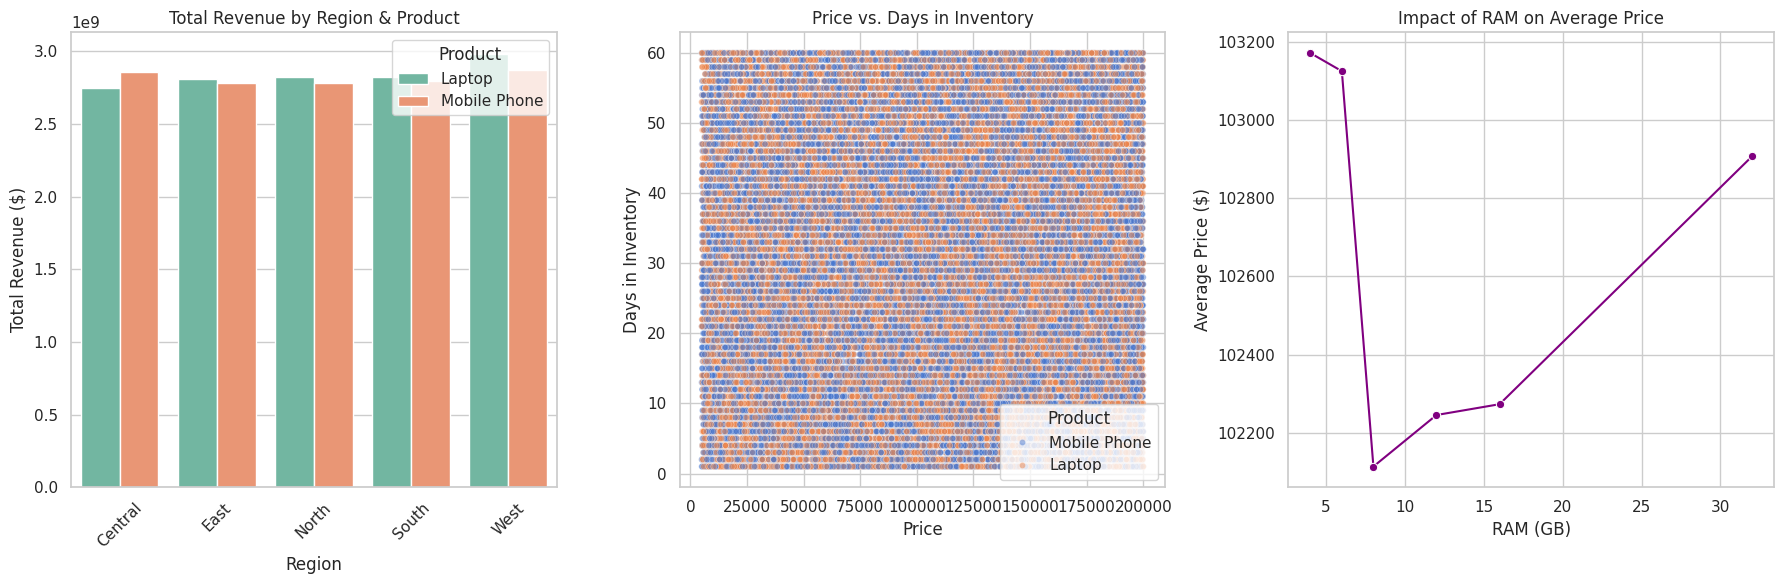

In [11]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import re


sns.set_theme(style="whitegrid", palette="muted")

print("Downloading and loading dataset...")
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "vinothkannaece/mobiles-and-laptop-sales-data",
    "mobile_sales_data.csv",
)

print("\n--- Initial Dataset Info ---")
print(df.info())



df_clean = df.copy()


df_clean['Inward Date'] = pd.to_datetime(df_clean['Inward Date'])
df_clean['Dispatch Date'] = pd.to_datetime(df_clean['Dispatch Date'])
df_clean['Days_In_Inventory'] = (df_clean['Dispatch Date'] - df_clean['Inward Date']).dt.days


df_clean['Days_In_Inventory'] = df_clean['Days_In_Inventory'].apply(lambda x: max(x, 0))


df_clean['Total_Revenue'] = df_clean['Price'] * df_clean['Quantity Sold']


def extract_gb(text):
    if pd.isna(text) or text == 'N/A':
        return 0

    if 'TB' in str(text).upper():
        nums = re.findall(r'\d+', str(text))
        return int(nums[0]) * 1024 if nums else 0
    nums = re.findall(r'\d+', str(text))
    return int(nums[0]) if nums else 0

df_clean['RAM_GB'] = df_clean['RAM'].apply(extract_gb)
df_clean['ROM_GB'] = df_clean['ROM'].apply(extract_gb)
df_clean['SSD_GB'] = df_clean['SSD'].apply(extract_gb)


df_clean = df_clean.dropna(subset=['Price'])


plt.figure(figsize=(18, 6))


plt.subplot(1, 3, 1)
revenue_summary = df_clean.groupby(['Region', 'Product'])['Total_Revenue'].sum().reset_index()
sns.barplot(data=revenue_summary, x='Region', y='Total_Revenue', hue='Product', palette='Set2')
plt.title('Total Revenue by Region & Product')
plt.xticks(rotation=45)
plt.ylabel('Total Revenue ($)')


plt.subplot(1, 3, 2)
sns.scatterplot(data=df_clean, x='Price', y='Days_In_Inventory', hue='Product', alpha=0.5, s=20)
plt.title('Price vs. Days in Inventory')
plt.xlabel('Price')
plt.ylabel('Days in Inventory')


plt.subplot(1, 3, 3)
avg_price_ram = df_clean[df_clean['RAM_GB'] > 0].groupby('RAM_GB')['Price'].mean().reset_index()
sns.lineplot(data=avg_price_ram, x='RAM_GB', y='Price', marker='o', color='purple')
plt.title('Impact of RAM on Average Price')
plt.xlabel('RAM (GB)')
plt.ylabel('Average Price ($)')

plt.tight_layout()
plt.show()


--- Predicting Price and Finding Feature Importance ---
Random Forest R-squared: -0.1183
Random Forest RMSE: 59607.93


/tmp/ipython-input-2215639932.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_imp_df, x='Importance', y='Feature', palette='magma')


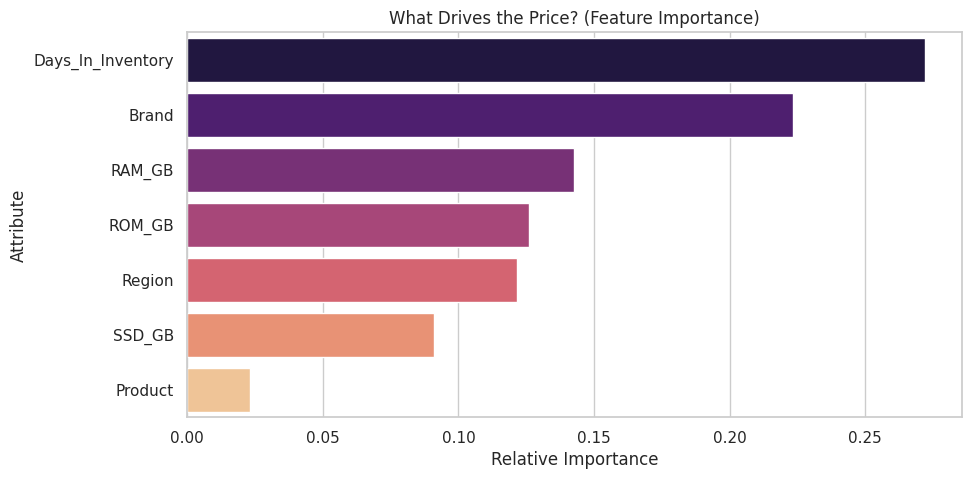

In [10]:

print("\n--- Predicting Price and Finding Feature Importance ---")

cat_cols = ['Product', 'Brand', 'Region']
le = LabelEncoder()
df_model = df_clean.copy()
for col in cat_cols:
    df_model[col] = le.fit_transform(df_model[col].astype(str))


ml_features = ['Product', 'Brand', 'Region', 'RAM_GB', 'ROM_GB', 'SSD_GB', 'Days_In_Inventory']
X = df_model[ml_features]
y = df_model['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print(f"Random Forest R-squared: {r2_score(y_test, y_pred):.4f}")
print(f"Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")


importance = rf_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': ml_features, 'Importance': importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=feature_imp_df, x='Importance', y='Feature', palette='magma')
plt.title('What Drives the Price? (Feature Importance)')
plt.xlabel('Relative Importance')
plt.ylabel('Attribute')
plt.show()